<h1 align="center">Classes Part 2 Classifying the Attractor Code</h1>

Say bye bye to LlamaLlama we are done with kid stories now its time to start growing up so lets jump back to our Strange Attractor code.

## Using Dictionaries for Function Calls

Lets look at another marvel of Python, the ability to create a dictionary of functions and then using the dictionary to dynamically call the functions. This is a prelude to the wonderful world of function callbacks which is the hallmark for GUI dynamic interaction with control state changes (we'll see this shortly!).

The basics of how this works is to create a dictionary where the key is a name that will be used to describe, and thus call, the function. The value is the actual function itself. If it is in a class it also must be prefaced with the 'self.' convention so the class knows its a member of the class object. Note, you do not add in the '()' as you normally would for a function! 

Next you create a new variable which is assigned the function desired by using the key to find the appropriate function from the dictionary.

This will make more sense in the following example.


In [1]:
class foo():
    def __init__(self):
        #Create a dictionary where the key is a description of the fxn and the value is the function itself
        self.fxn_dispatch = {"clifford":self.clifford,
                             "lorenz":self.lorenz, 
                             "pickover":self.pickover}
        #Create some dummy data for demoing parameter passing
        self.x=1
        self.y=2
        self.z=3

    def doit(self):
        
        #We are just creating a number of functions calls we want to make.
        keyCalls = ['lorenz','clifford','lorenz','pickover']
        
        #Iterate over keyVals and call each fxn based on the keys in keyCalls
        for key in keyCalls:
            #Call the fxn (the value) found from the associated key found from keyCalls
            self.fxn_dispatch[key](x=self.x,y=self.y,z=self.z)

    def clifford(self,x,y,z):
        print('Cifford Attractor:  x={}   y={}   z={}'.format(x,y,z))

    def lorenz(self,x,y,z):
        print('Lorenz Attractor:   x={}   y={}   z={}'.format(x,y,z))

    def pickover(self,x,y,z):
        print('Pickover Attractor: x={}   y={}   z={}'.format(x,y,z))

#Create an instance of class foo() and call it's doit() fxn.
a=foo()
a.doit()

Lorenz Attractor:   x=1   y=2   z=3
Cifford Attractor:  x=1   y=2   z=3
Lorenz Attractor:   x=1   y=2   z=3
Pickover Attractor: x=1   y=2   z=3


Pretty cool right!?! <br>
But if you think thats cool you should see what you can do with Python3's Enum's!!! But alas thats a different story for a longer day!

While we can add more attractors to our dictionary we will save that for a little bit. 

For the sake of time (meaning the lack of enough of) I have skipped ahead a bit and below I present to you a class oriented version of our attractor code. <br>
The code consists of 
- All the import
- A class called *Attractor_Config()* which loads out .atr file and gets the configuration of the desired attractor.
- A classed called *Attractors()* which handles all the attractor equations, calculating the particle trajectories, and rendering them with Datashader.
- The last cell contains the code for our *\__main__()*

In [5]:
import numpy as np
import pandas as pd
import datashader as ds
from datashader import transfer_functions as tf
from datashader import utils
import os
import time
from colorcet import palette

In [6]:
class Attractor_Config():
    """Utility class to open the Attractors configuration file
       and extract the parameters for a choosen attractor type"""
    
    def __init__(self, fName=""):
        self._df = None
        self._fName = fName
        self._coords = []
        self._params = []
        
        if self.fName is not None:
            self.get_AttractorConfigFile()
    
    def get_AttractorConfigFile(self):
        """Open the Attractors configuration file"""
        if os.path.isfile(self._fName) and os.access(self._fName, os.R_OK):
            self._df = pd.read_csv(self._fName)
            self._df.set_index('Attractor', inplace=True)   
        else:
            print("ERROR: The file is either missing or it's not readable")
            sys.exit(1)
    
    def getAttractor(self, fxn):
        """Get the configuration for the desired attractor"""
        a = self._df.loc[fxn]

        self._coords = [a.iloc[1], a.iloc[2], a.iloc[3]]

        self._params = np.array([])
        for v in range(4, np.size(a)):
            self._params = np.append(self._params, a.iloc[v])

        return self._coords, self._params
    
    @property
    def coords(self):
        """Getter - return coords"""
        return self._coords
    
    @property
    def df(self):
        """Getter - return df"""
        return self._df
    

    @property
    def fName(self):
        """Getter - return fName """
        return self._fName
    
    @property
    def params(self):
        """Getter - return params"""
        return self._params

    
    @df.setter
    def df(self, val):
        """Setter - sets df"""
        self._df = val
        
    @coords.setter
    def coords(self, val):
        """Setter - sets coords"""
        self._coords = val
        
    @fName.setter
    def fName(self, val):
        """Setter - sets fName"""
        self._fName = val
        
    @params.setter
    def fName(self, val):
        """Setter - sets params"""
        self._params = val
    
    

    

In [7]:
class Attractors(object):
    """ """
    def __init__(self, *args, **kwargs):
        self._n = 100000
        
        self.parse_kwargs(**kwargs)
        self.parse_coords()
        self.parse_avars()
        self._cmap = 'bgy'
    
    def parse_kwargs(self, **kwargs):
        svd_opts = ['fxn', 'coords', 'avars']
        
        for key in svd_opts:
          if key in kwargs:
            setattr(self, key, kwargs[key])

    def parse_coords(self):
        self.x = self.coords[0]
        self.y = self.coords[1]
        self.z = self.coords[2]

    def parse_avars(self):
        self._a = self.avars[0]
        self._b = self.avars[1]
        self._c = self.avars[2]
        self._d = self.avars[3]
        self._e = self.avars[4]
        self._f = self.avars[5]
    
    def Clifford(self,x,y,z):
        a = self._a
        b = self._b
        c = self._c
        d = self._d
        Xn = np.sin(a * y) + c * np.cos(a * x)
        Yn = np.sin(b * x) + d * np.cos(b * y)
        Zn = 0.0
        return Xn,Yn,Zn

    def trajectory(self, fn, n=0):
        fxn_dispatch = {'Clifford' : self.Clifford}
        
        x, y, z = np.zeros(self._n), np.zeros(self._n), np.zeros(self._n)
        x[0], y[0], z[0] = self.x, self.y, self.z
        for i in np.arange(self._n-1):
            x[i+1], y[i+1], z[i+1] = fxn_dispatch[self.fxn](x[i], y[i], z[i])#
        return pd.DataFrame(dict(x=x, y=y, z=z))

    def dsplot(self,fn, n=0, cmap='bgy'):
        """Return a Datashader image by collecting `n` trajectory points for the given attractor `fn`"""
        self._cmap = palette[cmap][::-1]
        if n:
            self._n = n
        df  = self.trajectory(fn, n=self._n)
        cvs = ds.Canvas(plot_width = 400, plot_height = 400)
        agg = cvs.points(df, 'x', 'y')
        img = tf.shade(agg, cmap=self._cmap)
        return img
    
    @property
    def cmap(self):
        """Getter - return cmap"""
        return self._cmap
    
    @cmap.setter
    def cmap(self, val):
        """Setter - sets cmap"""
        self._cmap = val
        
    

Time: 6.312326431274414


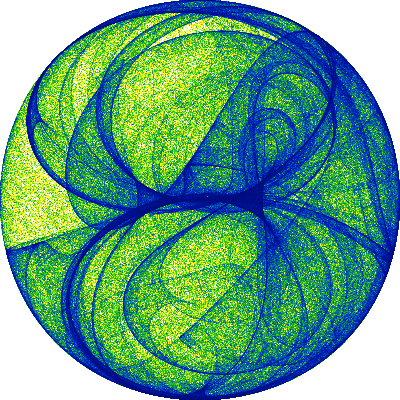

In [13]:
#if __name__ == '__main__':
#Note since we are working in a Jupyter Notebook and we want to display out Datashader image 
#the \__main__ is commented out. If you want to include it (ina Notebook) then 
#just run the lone 'img' in a new cell

fName = "attractors.atr"

attrConfig = Attractor_Config(fName)
#attrConfig.get_AttractorConfigFile()
coords, avars = attrConfig.getAttractor('Clifford')

attrType = 'Clifford'
start = time.time()
attr = Attractors(fxn=attrType, coords=coords, avars=avars)
attr.cmap = 'bgy'
img = attr.dsplot(fn=attrType,n = 1000000)
end = time.time()
print('Time: {}'.format(end-start))

img


### Exercise:
- Run the above code (remember you have to execute each cell)

## Saving a Datashader Image

That 'from datashader import utils' line I mentioned earlier and promised we'd discuss it later. It's later.<br>
*utils* has a few differnent cool features in it for now we will concentrate of just one of them, the ability to save Datashader images. 

To save an image you call the *utils.export_image(img, filename, fmt, background)* function
The parameters are list as:
- The actual image data itself (*img*)
- The name of the file you want it called. Do not add the file extensions to the name else it will be added twice.
- The file format you want it saved as (*.png*). In all honesty I'm not sure what other ones there are I always use pngs.
- The background color you want (or None)

### Exercise:
- Create a call to utils.export_image() to save a copy of your attractor.
- What happens if you replace None with a color such as Black? 


## Adding in New Strange Attractors

Now that see that we can easily add in more attractors (almost on the fly but not quite yet), lets finally add in the other attractors we saw listed in the configuration (.atr) file.

The equations for the equations we will add are listed below. 
Notes:
- There are 3D variants for all attractors but I left most of them in their original 2D constructs.
- For reasons you should now easily appreciate all equations use common parameters (a,b,c,d,e,f,g) so we can parse them from a single configuration file and dynamically call each equation at leisure. 
- A couple attractors have other internal variables which are created from the base parameters.

**Bedhead**<br>
$x[i+1] = sin\left(\frac{xy}{b}\right)*y + cos(ax-y) $<br>
$y[i+1] = x + \frac{sin(y)}{b} $<br>
$z[i+1] =  0.0 $<br>


**De Jong**<br>
$x[i+1] =  sin(ay) - cos(bx)$<br>
$y[i+1] =  sin(cx) - cos(dy)$<br>
$z[i+1] =  0.0 $<br>

**Pickover**<br>
$x[i+1] = sin(ay) - zcos(bx) $<br>
$y[i+1] = zsin(cx) - cos(dy) $<br>
$z[i+1] =  0.0 $<br>

**Fractal Dream**<br>
$x[i+1] = sin(yb)+csin(xb) $<br>
$y[i+1] = sin(xa)+dsin(ya) $<br>
$z[i+1] =  0.0 $<br>

**Gumowski**<br>
$x[i+1] = y + a(1 - by^2)y + G(x, c)$<br>
$y[i+1] = -x + G(x[i+1], c)$<br>
$z[i+1] = 0.0 $<br>
$G(x,c) = cx + 2(1 - c) * \left(\frac{x^2}{1.0 + x^2}\right)$

**Hopalong**<br>
$x[i+1] = y - \sqrt{|b x - c|} * sign(x) $<br>
$y[i+1] = a - x $<br>
$z[i+1] =  0.0 $<br>

**Icon**<br>
$r = (x*iy)^d $<br>
$p = c+a||d||+b(x_{real}-y_{imag}r)$<br>

$x[i+1] = px + g*z_{real}r - d*y $<br>
$y[i+1] = py - gz_{imag} + d*x $<br>
$z[i+1] =  ||d|| $<br>

**Lorenz**<br>
$x[i+1] = x+ad(y-x)  $<br>
$y[i+1] = y+d(bx-y-zx) $<br>
$z[i+1] = z+d(xy-cz) $<br>

**Lorenz84**<br>
$x[i+1] = x+d(-ax-yy-zz+af)$<br>
$y[i+1] = y+d(-y+xy-b*xz+g)$<br>
$z[i+1] = z+d(-z+bxy+xz) $<br>

**Poly A**<br>
$x[i+1] = a+y-z*y $<br>
$y[i+1] = b+z-x*z $<br>
$z[i+1] = c+x-y*x $<br>

**Svensson**<br>
$x[i+1] = dsin(ax) - sin(by)$<br>
$y[i+1] = ccos(ax) + cos(by) $<br>
$z[i+1] =  0.0 $<br>


The associated functions for each of the above attractors is listed below.

In [ ]:
    def Bedhead(self,x,y,z):
      a = self.a
      b = self.b
      Xn = np.sin(x*y/b)*y + np.cos(a*x-y)
      Yn = x + sin(y)/b
      Zn = 0.0
      return Xn,Yn,Zn
      
    def Clifford(self,x,y,z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = np.sin(a * y) + c * np.cos(a * x)
      Yn = np.sin(b * x) + d * np.cos(b * y)
      Zn = 0.0
      return Xn,Yn,Zn
           
    def De_Jong(self,x,y,z):
      Xn = sin(self.a * y) - cos(self.b * x)
      Yn = sin(self.c * x) - cos(self.d * y)
      Zn = 0.0
      return Xn, Yn, Zn       
           
           
           
    def Pickover(self,x,y,z): 
      Xn =  np.sin(self.a*y) - z*np.cos(self.b*x)
      Yn =  z*np.sin(self.c*x) - np.cos(self.d*y)
      Zn =  np.sin(x) 
      return Xn, Yn, Zn

    def Fractal_Dream(self, x, y, z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = np.sin(y*b)+c*np.sin(x*b)
      Yn = np.sin(x*a)+d*np.sin(y*a)
      Zn = 0.0
      return Xn,Yn,Zn

    def GM_G(self, x, mu):
      return mu * x + 2 * (1 - mu) * x**2 / (1.0 + x**2)

    def Gumowski_Mira(self,x, y, z):
      a = self.a
      b = self.b
      mu = self.c
      
      Xn = y + a*(1 - b*y**2)*y  +  self.GM_G(x, mu)
      Yn = -x + self.GM_G(Xn, mu)
      Zn = 0.0
      return Xn, Yn, Zn

    def Hopalong(self, x, y, z):
      a = self.a
      b = self.b
      c = self.c
      Xn = y - np.sqrt(np.fabs(b * x - c)) * np.sign(x)
      Yn = a - x
      Zn = 0.0
      return Xn,Yn,Zn
   
    def Icon(self, x, y, z):#a, b, g, om, l, d,
      a = self.a
      b = self.b
      g = self.c 
      om = self.d
      l = self.e
      d = np.int(self.f)
      zzbar = x*x + y*y
      p = a*zzbar + l
      zreal, zimag = x, y
      for i in range(1, d-1):
        za, zb = zreal * x - zimag * y, zimag * x + zreal * y
        zreal, zimag = za, zb
      
      zn = x*zreal - y*zimag
      p += b*zn
      
      Xn = p*x + g*zreal - om*y
      Yn = p*y - g*zimag + om*x
      Zn = 0.0
      return Xn, Yn, Zn   
        
    def Lorenz(self,x,y,z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = x+a*d*(y-x)
      Yn = y+d*(b*x-y-z*x)
      Zn = z+d*(x*y-c*z)
      return Xn, Yn, Zn
        
    def Lorenz84(self,x,y,z):
      a = self.a
      b = self.b
      f = self.c
      g = self.d
      d = self.e
      Xn = x+d*(-a*x-y*y-z*z+a*f)
      Yn = y+d*(-y+x*y-b*x*z+g)
      Zn = z+d*(-z+b*x*y+x*z)
      return Xn, Yn, Zn
        
    def Poly_A(self,x,y,z):
      p0 = self.a
      p1 = self.b
      p2 = self.c 
      Xn = p0+y-z*y
      Yn = p1+z-x*z
      Zn = p2+x-y*x 
      return Xn,Yn,Zn
  
    def Svensson(self,x, y,z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = d * np.sin(a * x) - np.sin(b * y)
      Yn = c * np.cos(a * x) + np.cos(b * y)
      Zn = 0.0
      return Xn, Yn, Zn

The final (for now) Attractor class looks like this.
I'll take a couple minutes to explain a couple changes and where we are headed with them.

In [15]:
class Attractors(object):
    """ """
    def __init__(self, *args, **kwargs):
        self.first = False
        
        self.parse_kwargs(**kwargs)
        self.parse_coords()
        self.parse_avars()
        self._attrType = ''
        self._aOrientation = 'XY'
        self._cmap = 'bgy'
        self._res = 400

    def parse_kwargs(self, **kwargs):
        svd_opts = ['fxn', 'coords', 'avars']
        
        for key in svd_opts:
          if key in kwargs:
            setattr(self, key, kwargs[key])

    def parse_coords(self):
        self.x = self.coords[0]
        self.y = self.coords[1]
        self.z = self.coords[2]

    def parse_avars(self):
        self.a = self.avars[0]
        self.b = self.avars[1]
        self.c = self.avars[2]
        self.d = self.avars[3]
        self.e = self.avars[4]
        self.f = self.avars[5]

    def Bedhead(self,x,y,z):
      a = self.a
      b = self.b
      Xn = np.sin(x*y/b)*y + np.cos(a*x-y)
      Yn = x + sin(y)/b
      Zn = 0.0
      return Xn,Yn,Zn
      
    def Clifford(self,x,y,z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = np.sin(a * y) + c * np.cos(a * x)
      Yn = np.sin(b * x) + d * np.cos(b * y)
      Zn = 0.0
      return Xn,Yn,Zn
           
    def De_Jong(self,x,y,z):
      Xn = sin(self.a * y) - cos(self.b * x)
      Yn = sin(self.c * x) - cos(self.d * y)
      Zn = 0.0
      return Xn, Yn, Zn       
           
    def Pickover(self,x,y,z): 
      Xn =  np.sin(self.a*y) - z*np.cos(self.b*x)
      Yn =  z*np.sin(self.c*x) - np.cos(self.d*y)
      Zn =  np.sin(x) 
      return Xn, Yn, Zn

    def Fractal_Dream(self, x, y, z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = np.sin(y*b)+c*np.sin(x*b)
      Yn = np.sin(x*a)+d*np.sin(y*a)
      Zn = 0.0
      return Xn,Yn,Zn

    def GM_G(self, x, mu):
      return mu * x + 2 * (1 - mu) * x**2 / (1.0 + x**2)

    def Gumowski_Mira(self,x, y, z):
      a = self.a
      b = self.b
      mu = self.c
      
      Xn = y + a*(1 - b*y**2)*y  +  self.GM_G(x, mu)
      Yn = -x + self.GM_G(Xn, mu)
      Zn = 0.0
      return Xn, Yn, Zn

    def Hopalong(self, x, y, z):
      a = self.a
      b = self.b
      c = self.c
      Xn = y - np.sqrt(np.fabs(b * x - c)) * np.sign(x)
      Yn = a - x
      Zn = 0.0
      return Xn,Yn,Zn
   
    def Icon(self, x, y, z):#a, b, g, om, l, d,
      a = self.a
      b = self.b
      g = self.c 
      om = self.d
      l = self.e
      d = np.int(self.f)
      zzbar = x*x + y*y
      p = a*zzbar + l
      zreal, zimag = x, y
      for i in range(1, d-1):
        za, zb = zreal * x - zimag * y, zimag * x + zreal * y
        zreal, zimag = za, zb
      
      zn = x*zreal - y*zimag
      p += b*zn
      
      Xn = p*x + g*zreal - om*y
      Yn = p*y - g*zimag + om*x
      Zn = 0.0
      return Xn, Yn, Zn   
        
    def Lorenz(self,x,y,z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = x+a*d*(y-x)
      Yn = y+d*(b*x-y-z*x)
      Zn = z+d*(x*y-c*z)
      return Xn, Yn, Zn
        
    def Lorenz84(self,x,y,z):
      a = self.a
      b = self.b
      f = self.c
      g = self.d
      d = self.e
      Xn = x+d*(-a*x-y*y-z*z+a*f)
      Yn = y+d*(-y+x*y-b*x*z+g)
      Zn = z+d*(-z+b*x*y+x*z)
      return Xn, Yn, Zn
        
    def Poly_A(self,x,y,z):
      p0 = self.a
      p1 = self.b
      p2 = self.c 
      Xn = p0+y-z*y
      Yn = p1+z-x*z
      Zn = p2+x-y*x 
      return Xn,Yn,Zn
  
    def Svensson(self,x, y,z):
      a = self.a
      b = self.b
      c = self.c
      d = self.d
      Xn = d * np.sin(a * x) - np.sin(b * y)
      Yn = c * np.cos(a * x) + np.cos(b * y)
      Zn = 0.0
      return Xn, Yn, Zn

    def trajectory(self):
        fxn_dispatch = {'Bedhead':self.Bedhead,
                        'Clifford':self.Clifford,
                        'De_Jong':self.De_Jong, 
                        'De_Jong1':self.De_Jong, 
                        'Fractal_Dream':self.Fractal_Dream,
                        'Gumowski_Mira':self.Gumowski_Mira,
                        'Hopalong':self.Hopalong,
                        'Icon':self.Icon,
                        'Lorenz':self.Lorenz, 
                        'Lorenz84':self.Lorenz84, 
                        'Pickover':self.Pickover, 
                        'Poly_A':self.Poly_A,
                        'Svensson':self.Svensson,
                        }
 
        x, y, z = np.zeros(self._numIters), np.zeros(self._numIters), np.zeros(self._numIters)
        x[0], y[0], z[0] = self.x, self.y, self.z
        for i in np.arange(self._numIters-1):
            x[i+1], y[i+1], z[i+1] = fxn_dispatch[self.fxn](x[i], y[i], z[i])
        return pd.DataFrame(dict(x=x, y=y, z=z))

    def dsplot(self): 
        """Return a Datashader image by collecting `n` trajectory points for the given attractor `fn`"""
        cmap = palette[self._cmap][::-1]
        start = time.time()
        df  = self.trajectory()
        end = time.time()
        self._timeCalc = end - start
        start = time.time()
        cvs = ds.Canvas(plot_width = self._res, plot_height = self._res)
        
        if self._aOrientation == 'XY':
          agg = cvs.points(df, 'x', 'y')
        elif self._aOrientation == 'XZ':
          agg = cvs.points(df, 'x', 'z')
        else:
          agg = cvs.points(df, 'y', 'z')

        img = tf.shade(agg, cmap=cmap)
        end = time.time()
        self._timeRender = end - start
        self.saveImg(img=img,tmp=True)
        return img
    
    '''
    def plot(self):
        """Plot the given attractor `fn` once per provided set of arguments."""
        return tf.Images(self.dsplot())
    '''
    
    def saveImg(self,img, fName='', tmp=False):
      if tmp:
        fName = 'tempAttr'
      
      utils.export_image(img=img,filename=fName, fmt=".png", background=None)

        
    @property
    def attrType(self):
      return self._attrType
    
    @property
    def aOrientation(self):
      return self._aOrientation
        
    @property
    def cmap(self):
      """Getter - return cmap"""
      return self._cmap
  
    @property
    def numIters(self):
      return self._numIters
  
    @property
    def res(self):
      return self._res
    
    @cmap.setter
    def cmap(self, val):
      """Setter - sets cmap"""
      self._cmap = val
      
    @numIters.setter
    def numIters(self, val):
      self._numIters = val
      
    @attrType.setter  
    def attrType(self, val):
      self._attrType = val
      
    @aOrientation.setter
    def aOrientation(self, val):
      self._aOrientation = val
      
    @res.setter
    def res(self, val):
      self._res = val

Do not bother running the above code it will not work for you without several changes to the other sections of code. Instead lets move on and get a glimpse of where it comes from and why.